In [1]:
import os
import glob
import json
import datetime
import calendar
import logging
import numpy as np
import matplotlib.pyplot as plt

##  Configure logging

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Files and directories

In [21]:
datadir = '/home/ctroupin/Data/Stareso/Wind/'
figdir = './figures/'
datafile1 = os.path.join(datadir, "winddirection20170511.js")
datafile2 = os.path.join(datadir, "windspeed20170511.js")
datafile3 = os.path.join(datadir, "windgust20170511.js")

In [22]:
if not os.path.exists(datafile1):
    logging.warn("{0} doesn't exist".format(datafile1))
else:
    logging.debug("File {0} exists".format(datafile1))
if not os.path.exists(datafile2):
    logging.warn("{0} doesn't exist".format(datafile2))
else:
    logging.debug("File {0} exists".format(datafile2))
if not os.path.exists(datafile3):
    logging.warn("{0} doesn't exist".format(datafile3))
else:
    logging.debug("File {0} exists".format(datafile3))

DEBUG:root:File /home/ctroupin/Data/Stareso/Wind/winddirection20170511.js exists
DEBUG:root:File /home/ctroupin/Data/Stareso/Wind/windspeed20170511.js exists
DEBUG:root:File /home/ctroupin/Data/Stareso/Wind/windgust20170511.js exists


# Read data

Convert the json files to python lists using the `json` module.

In [54]:
with open(datafile1, 'r') as f:
    data = f.readline()
winddirectiondata = json.loads(data)
with open(datafile2, 'r') as f:
    data = f.readline()
windspeeddata = json.loads(data)
with open(datafile3, 'r') as f:
    data = f.readline()
windgustdata = json.loads(data)

We separate time and the actual measurements:

In [55]:
time1 = []
time2 = []
winddirection = []
windspeed = []
windgust = []
for d in winddirectiondata:
    time1.append(d[0])
    winddirection.append(d[1])
for d in windspeeddata:
    time2.append(d[0])
    windspeed.append(d[1])
for d in windgustdata:
    time2.append(d[0])
    windgust.append(d[1])

Convert list to numpy arrays:

In [56]:
winddirection = np.array(winddirection)
windgust = np.array(windgust)
windspeed = np.array(windspeed)

Convert time to dates

In [57]:
dates = list(map(lambda x: datetime.datetime.fromtimestamp(x / 1000.), time1))

# Create plots

## Time series 

### Wind direction

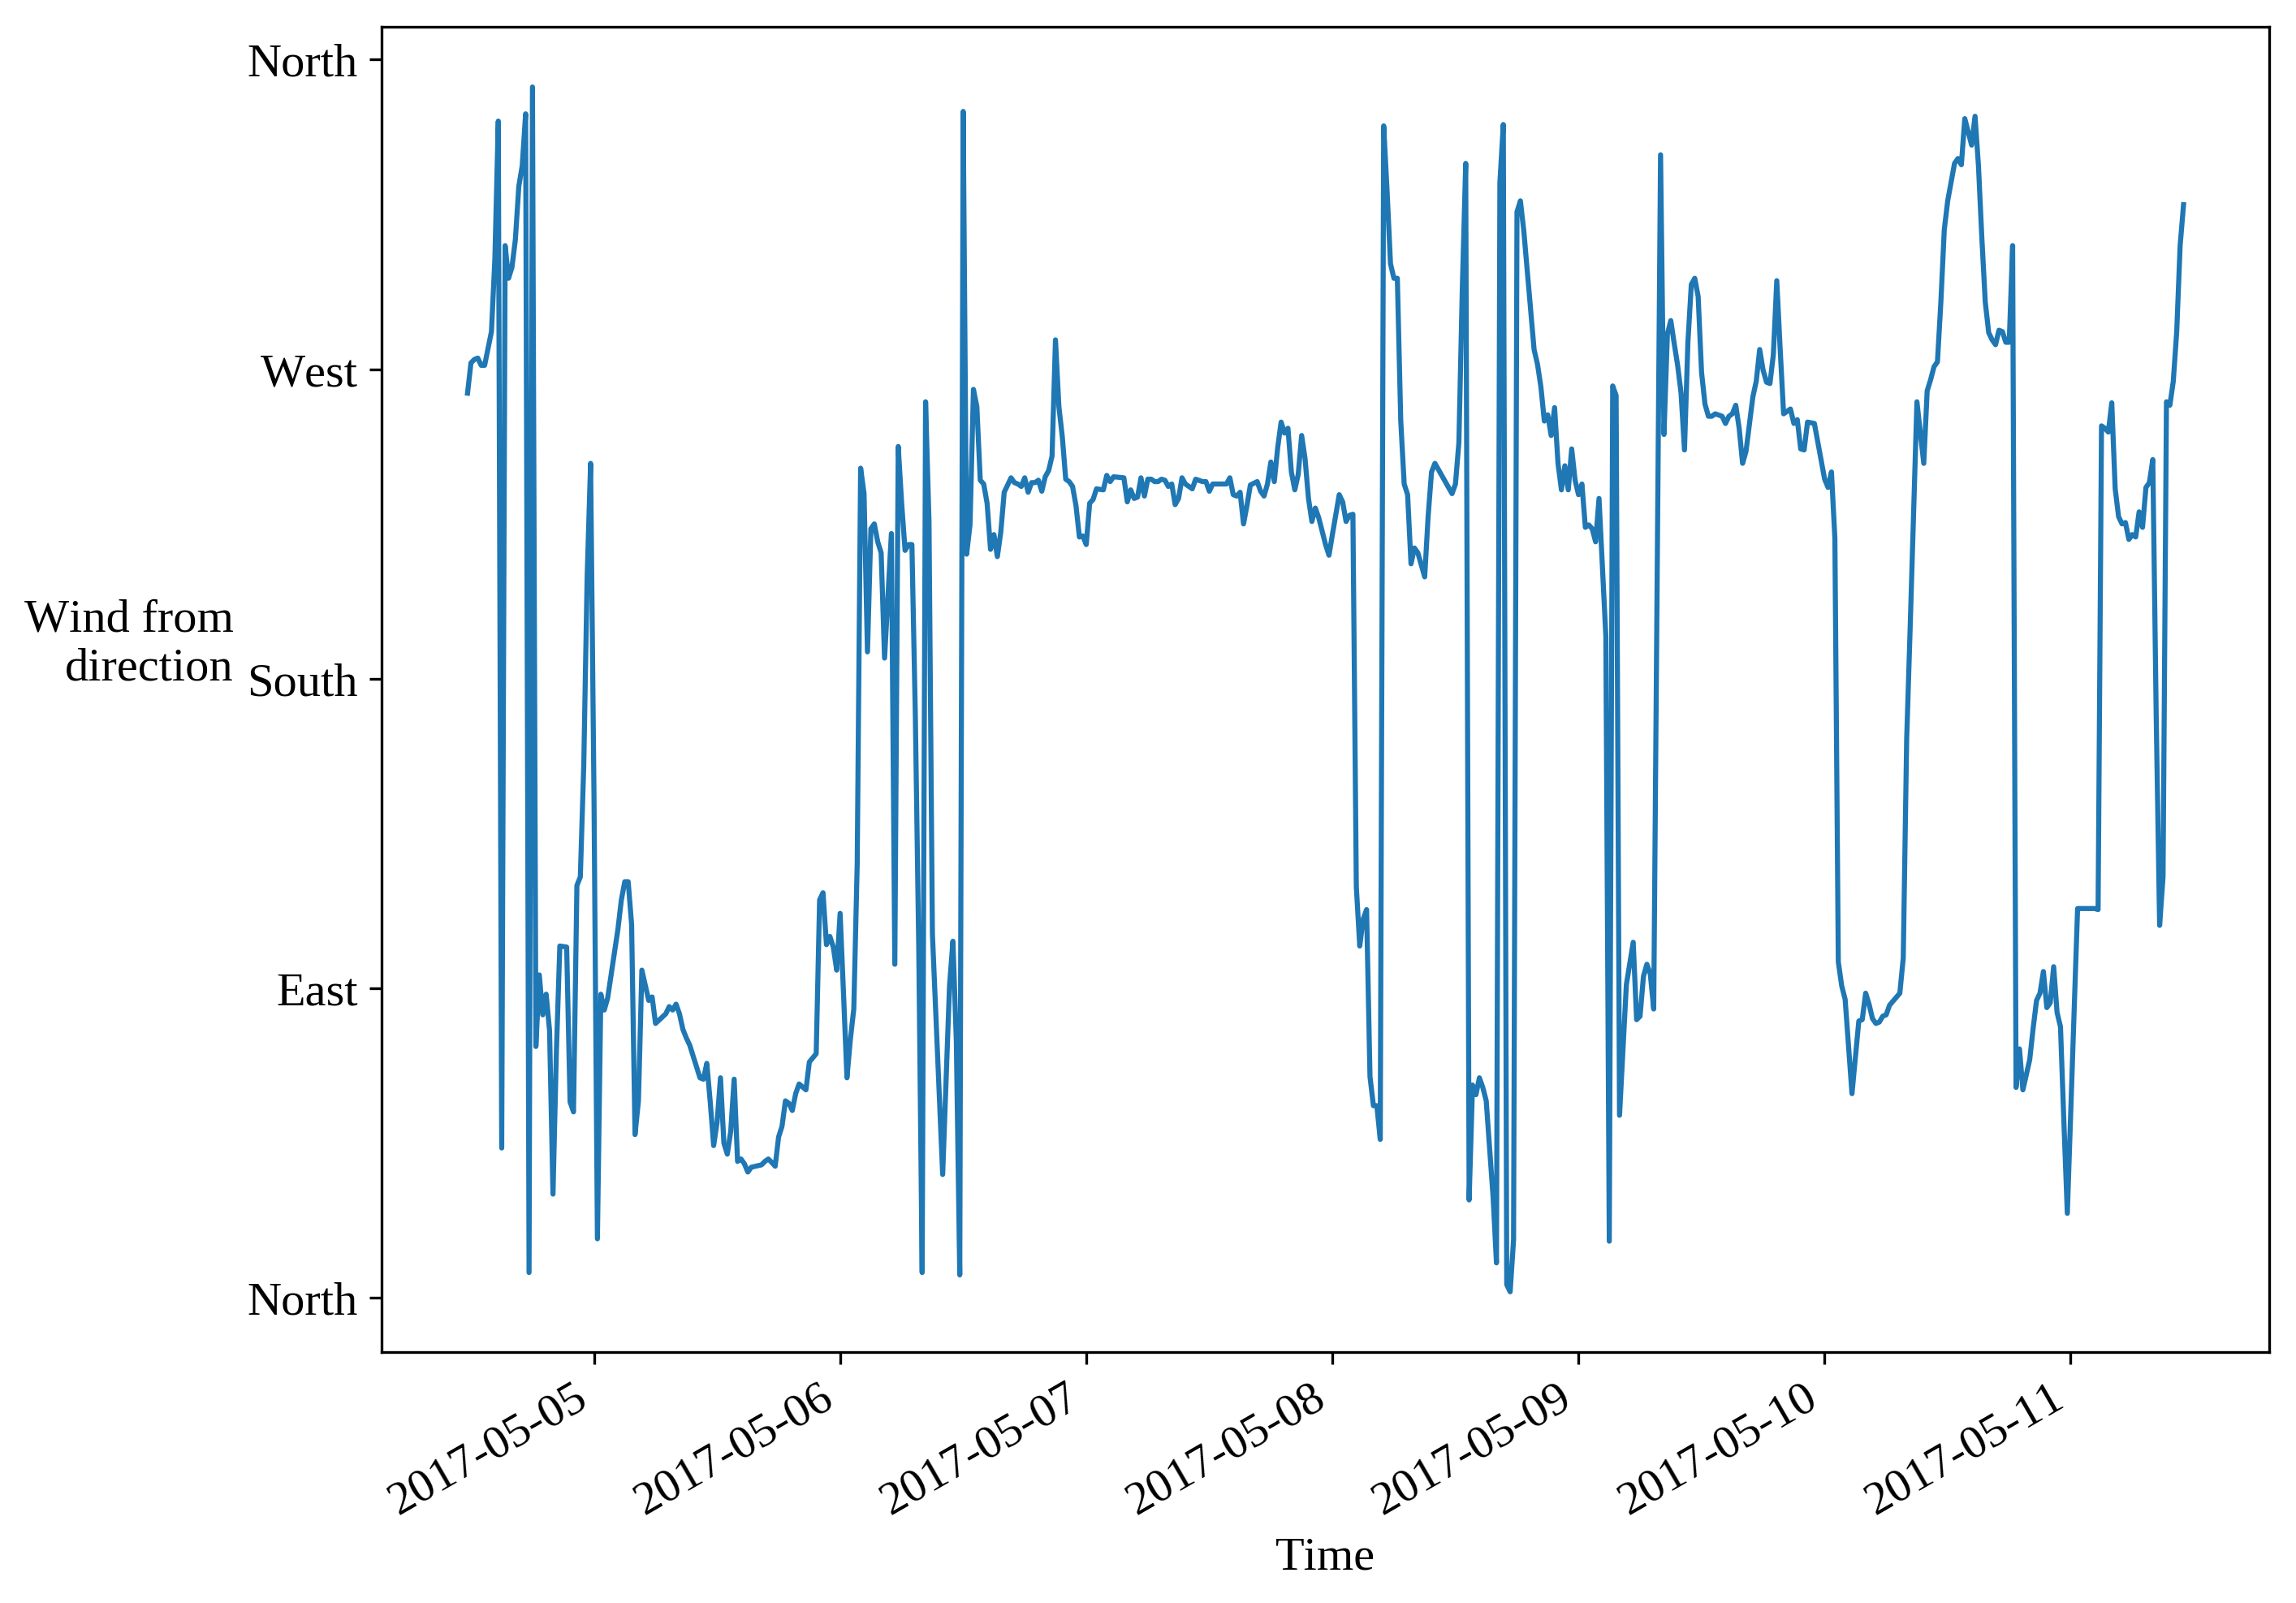

In [58]:
fig = plt.figure()
plt.plot(dates, winddirection)
plt.xlabel("Time")
plt.ylabel("Wind from\ndirection", rotation=0, ha='right')
plt.yticks([0, 90, 180, 270, 360], ["North", "East", "South", "West", "North"])
plt.gcf().autofmt_xdate()
plt.savefig(os.path.join(figdir, 'winddirection_line_20170511.png'))
plt.show()
plt.close()

### Wind speed and gust

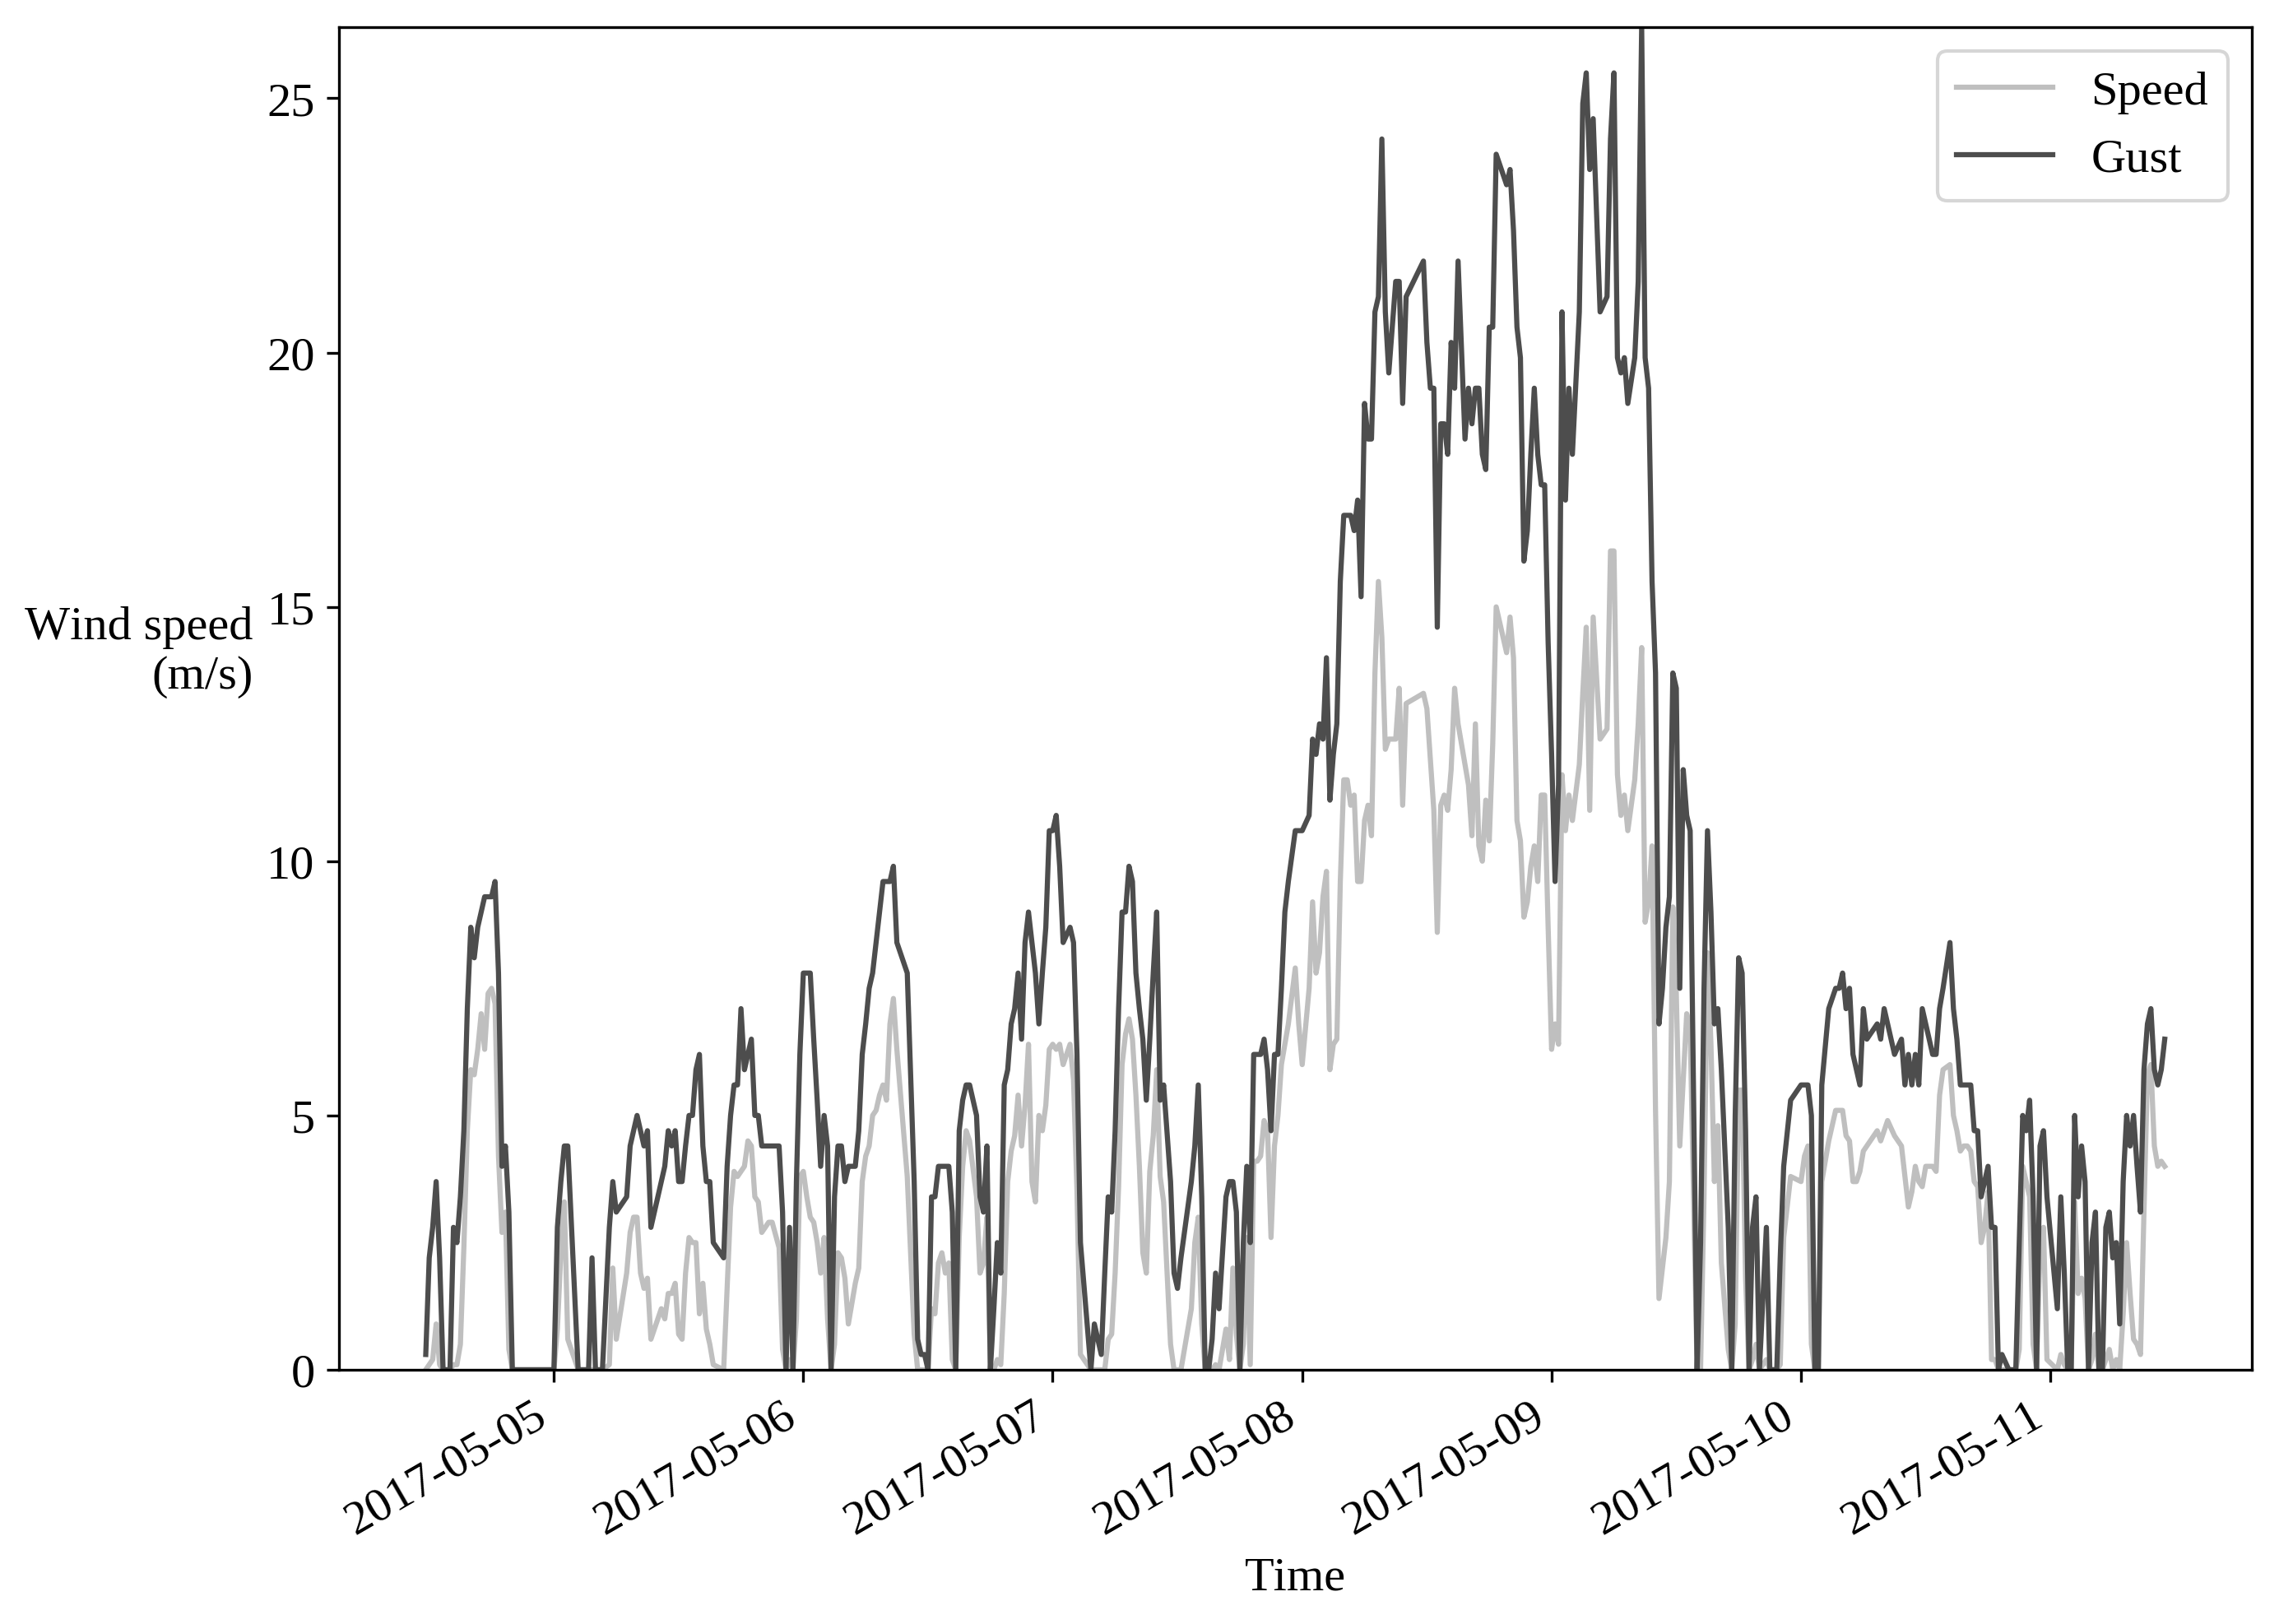

In [59]:
fig = plt.figure()
plt.plot(dates, windspeed, color='.75', label='Speed')
plt.plot(dates, windgust, color='.3', label='Gust')
plt.xlabel("Time")
plt.ylabel("Wind speed\n(m/s)", rotation=0, ha='right')
plt.ylim(0, windgust.max())
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig(os.path.join(figdir, 'windspeed_20170511.png'))
plt.show()
plt.close()

## Vector plot

Compute components and reverse to show where wind is going (more visual).

In [60]:
winddirectionrad = np.deg2rad(winddirection)
xwind = -np.sin(winddirectionrad)
ywind = -np.cos(winddirectionrad)

Prepare xticks and xticklabels:

In [42]:
def datexticks(numdays=8, deltadays=1):
    """Generate list of xticks and xticklabels every day,
    from to the current day to *numdays* in the past
    
    Parameter:
    numdays: number of days to go in the past (default: 8)
    deltadays: number of days between 2 consecutive xticks (default: 1)
    
    Return:
    datesxticks: list of xticks
    datesxticklabels: list of xticklabels (formated dates)
    """
    base = datetime.datetime.today()
    today = datetime.datetime(base.year, base.month, base.day)
    date_list = [today - datetime.timedelta(days=x) for x in range(0, numdays, deltadays)]
    # date_list.reverse()
    # Empty lists
    datesxticks = []
    datesxticklabels = []
    for dates in date_list:
        datesxticks.append(calendar.timegm(dates.timetuple()))
        datesxticklabels.append(datetime.datetime.strftime(dates, "%Y-%m-%d"))
    return datesxticks, datesxticklabels

In [43]:
datesxticks, datesxticklabels = datexticks(8)

## Quiver figure

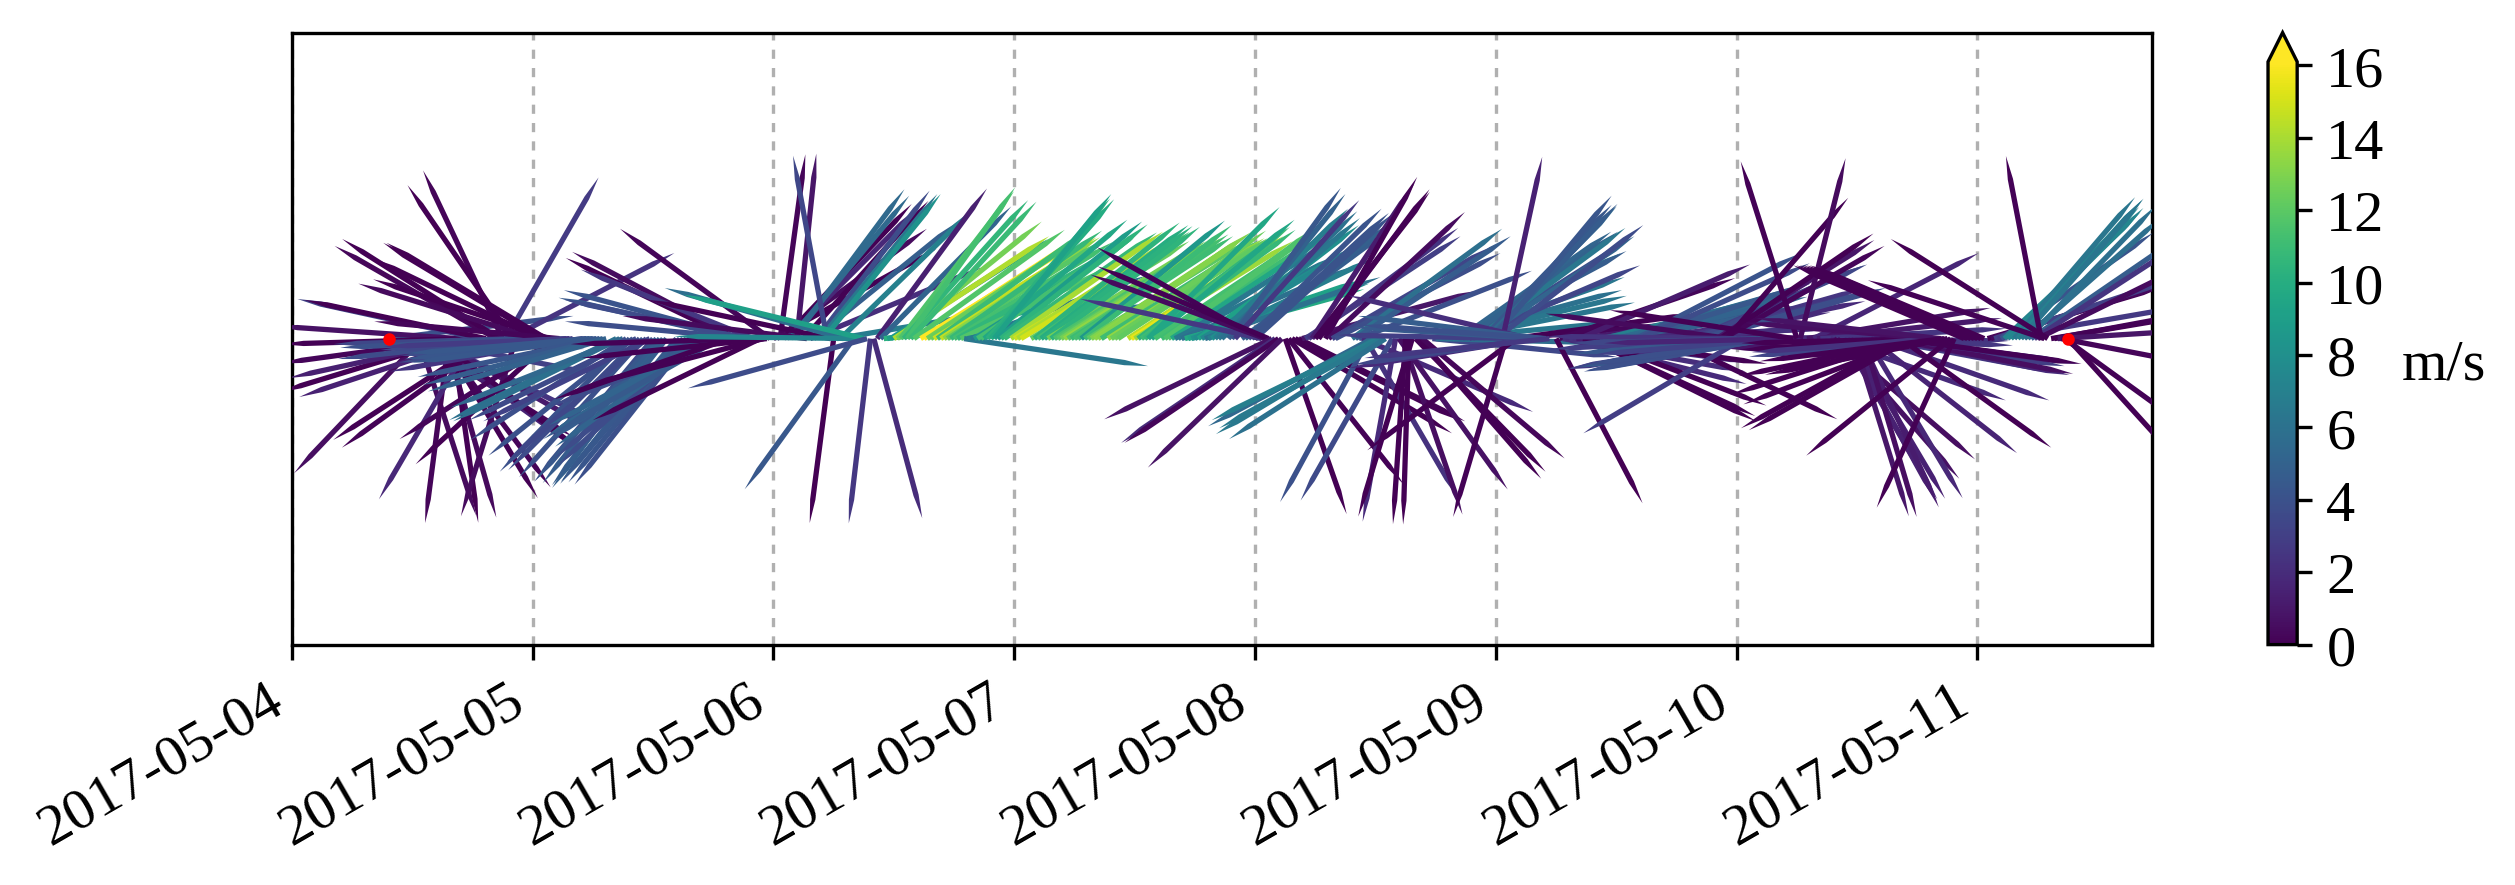

In [20]:
fig = plt.figure(figsize=(10, 3))
pgca = plt.gca()
pgca.axes.get_yaxis().set_visible(False)
q = plt.quiver(np.array(time1) / 1000., 0, xwind, ywind, np.flipud(np.array(windspeed)), 
           scale=10, headwidth=0, headlength=0, linewidth=.2, angles='uv', zorder=4)
plt.plot(time1[-1] / 1000., 0, 'ro', ms=2, zorder=5)
plt.plot(time1[0] / 1000., 0, 'ro', ms=2, zorder=5)

cb = plt.colorbar(q, extend='max')
cb.set_label('m/s', rotation=0, ha='left')
plt.xticks(datesxticks, datesxticklabels)
plt.gcf().autofmt_xdate()
plt.grid(linestyle=":", zorder=2)
plt.savefig(os.path.join(figdir, 'winddirection20170511.png'), 
            bbox_inches='tight')
plt.show()
plt.close()

## Wind rose

In [47]:
from windrose import WindroseAxes

/usr/local/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


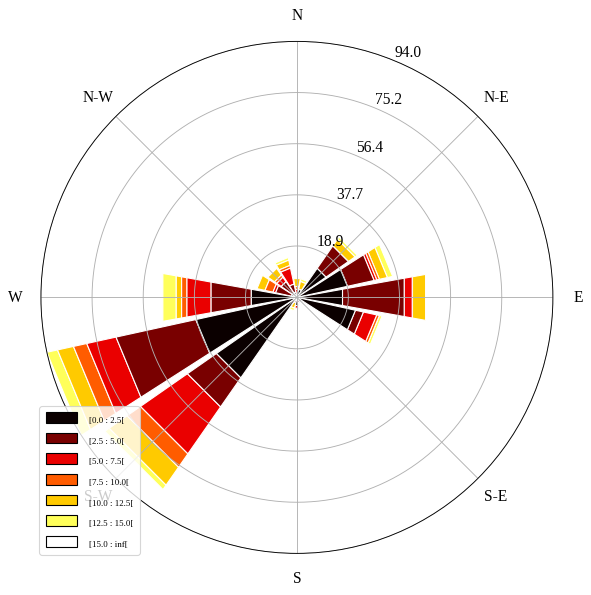

In [73]:
fig = plt.figure()
ax = WindroseAxes.from_ax()
ax.bar(winddirection, windspeed, bins=np.arange(0, 17.5, 2.5), 
       opening=0.9, edgecolor='w', cmap=plt.cm.hot)
ax.set_legend()
plt.savefig(os.path.join(figdir, "windrose-20170511.png"), 
            bbox_inches='tight', dpi=300)
plt.show()
plt.close()